<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/propensity_weighted_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will use propensity score we got from the logistic regression to do weighted analysis of ATE.

# 0. load data/packages

In [1]:
cd drive/My\ Drive/fall

/content/drive/My Drive/fall


In [2]:
ls

counties_with_diff_and_all_covariates.csv
counties_with_diff.csv
county_data_with_covariates.csv
county_data_with_reduced_covariates_more_variables.csv
county_data_with_reduced_covariates_with_SIP.csv
county_data_with_reduced_covariates_with_SIP_up_to_5.csv
county_data_with_reduced_covariates_with_SIP_up_to_8.csv
LR_with_propensity_compare_SIP_and_no_SIP.ipynb
LR_with_propensity_score_buckets.ipynb
more_mutual_info.ipynb
propensity_weighted_method.ipynb
PSM_new.ipynb
standardized_linear_regression.ipynb
what_make_people_change_behavior.ipynb


In [3]:
import pandas as pd
import numpy as np

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")
# load MatchIt package
library(MatchIt)
# install optimal match package
install.packages('optmatch')
library(optmatch)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/MatchIt_3.0.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 317607 bytes (310 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

In [73]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [22]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘png’, ‘jpeg’, ‘gbm’, ‘survey’, ‘latticeExtra’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

In [114]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [115]:
data.dropna(inplace = True)

In [116]:
print(f"after dropping this dataset has {data.shape[0]} records.")

after dropping this dataset has 2995 records.


In [117]:
dataframe = data

# 1. get propensity score from logistic regression

In [10]:
dataframe.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


Since we are doing propensity weighted methods, we do not need to use the matchit package (we could), we can just use GLM package to do logistic regression to get a propensity score for each row.

In [118]:
%%R -i dataframe

logitModel <- glm(SIP.~Median.Household.Income + X..Rural +
                  political_diff+
                  X..Asian + X..Black + 
                  X..Non.Hispanic.White +
                  X..Hispanic + Population_y, data = dataframe, family = "binomial")

# put the propensity score predicted by logistic regression
# into a new column in the dataframe.
dataframe$weights<-predict(mylogit, type="response")

In [15]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

# 2. box-whisker plot of propensity score distribution

In [119]:
%%R
# convert 0, 1 to categories, as is required by the box whisker function
dataframe$factor_SIP <- factor(dataframe$SIP.)

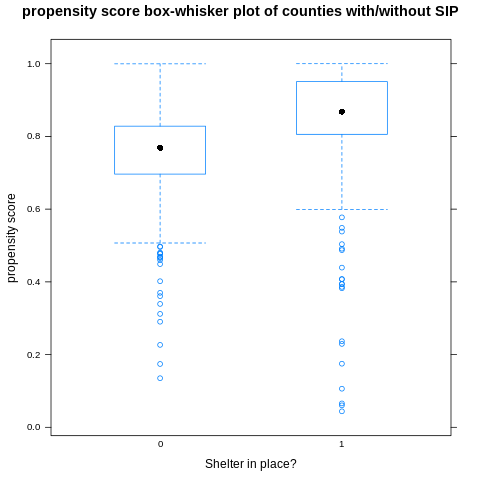

In [124]:
%%R
bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
       xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
       auto.key = TRUE) 

As we can see, although the box whisker plot don't overlap exactly, I still think we still got a good propensity score based on the graph

# 3. calculate weight of each individual based on propensity score

There are two different ways to do propensity score weighting, one is used to estimate ATT, another is used to esimate ATE. In this case we are estimating ATE, so the formula we will be using will be:
$w_i=\frac{Z_{i}}{e_i(X)}+\frac{1-Z_i}{1-e_i(X)}$ (Stuart, 2010) where $Z_i$ is the treatment random variable for individual $i$. ($Z_i = 1$ for treated). $e_i$ is the propensity score the individual $i$. 

The intuition for this formula is this: If an individual has propensity score of 0.1, but actually got the treatment, we weight that individual by a lot ($\frac{1}{0.1}$)because that is unusual. The same goes for the other side: if an individual has propensity score of 0.9, but didn't get the treatment, then we weight that individual by ($\frac{1}{1-0.9}$) 

In [125]:
%%R
dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))

In [126]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [127]:
%%R
with(dataframe, by(weight_ATE, SIP., summary))

SIP.: 0
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.156    3.293    4.314   18.141    5.821 2181.759 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.052   1.153   1.193   1.241  22.744 


We can see we have extremem high weights on the distribution of data points with `SIP. == 0` 

Propensity score weighting may result in extreme weights, which inflate the standard errors of the treatment
estimates (Robins et al., 2000) and may also increase bias (Harder et al., 2010).  Extreme weights may be due
to model misspecification and/or lack of common support of propensity score distributions. 

Extreme weights don't happen for ATT estimations usually
**Although there is no consensus in the research community on how large the weights count as "extreme", I consider a maximum of 2181 pretty abnormal weight.** (generally a weight that is greater than a 100 is considered large)

# 4. deal with extreme weights

There are a couple of ways to deal with extreme weights. One is to truncate the weights that are greater than 99th percentile.  Gurel
and Leite (2012) found that truncating weights at the 99th percentile decreased bias removal compared with
using untruncated weights and that the decrease in bias removal increased as the ratio of treated to untreated
became smaller

In [133]:
%%R
dataframe$weight_ATE_truncated <- with(dataframe, 
                                       ifelse(weight_ATE > quantile(weight_ATE, 0.99),
                                              quantile(weight_ATE, 0.99),
                                              weight_ATE))

In [137]:
%%R
with(data = dataframe, by(weight_ATE_truncated, SIP., summary))

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.156   3.293   4.314   5.434   5.821  15.622 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.052   1.153   1.190   1.241  15.622 


Another method to deal with extreme weights is to use stabilized weights (Robins et al., 2000). I think our method above worked pretty well as it reduced the maximum weights to 15, so I wouldn't try that method here.

# 5. check covariate balance

In [142]:
%%R
covariateNames <- c('Median.Household.Income', 'X..Rural', 'political_diff',
                    'X..Asian', 'X..Black', 'X..Non.Hispanic.White', 'X..Hispanic',
                    'Population_y')

In [166]:
%%R
# sampw has to be set here or else will not get std.eff.sz which is what we want
# since we don't have sampling weight, we set it to 1
balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                         w.all = dataframe$weight_ATE_truncated, sampw = 1,
                         get.ks = F, estimand = 'ATE', multinom = F)

In [167]:
%%R
balance_results <- balanceTable$results 

In [168]:
%%R
round(balance_results,3) 

                             tx.mn      tx.sd     ct.mn     ct.sd std.eff.sz
Median.Household.Income  53051.241  14417.540 51569.742 10744.760      0.106
X..Rural                    56.589     30.318    59.114    31.010     -0.082
political_diff              -0.303      0.305    -0.347     0.245      0.145
X..Asian                     1.597      2.845     1.267     1.583      0.117
X..Black                     9.242     14.246     8.197    13.994      0.072
X..Non.Hispanic.White       74.905     21.529    79.179    15.612     -0.215
X..Hispanic                  9.598     13.995     7.383     7.467      0.160
Population_y            108364.333 338528.175 51673.108 95951.612      0.166
                          stat     p
Median.Household.Income  2.033 0.042
X..Rural                -1.303 0.193
political_diff           2.658 0.008
X..Asian                 2.834 0.005
X..Black                 0.970 0.332
X..Non.Hispanic.White   -3.484 0.001
X..Hispanic              4.192 0.000
Population_

As we can see, the `std.eff.sz` are close to 0.1 - 0.15 for all variables, and below 0.25 for all variables, which is good

Absolute standardized effect sizes below 0.1 standard deviations can be considered to
indicate adequate covariate balance (Austin, 2011b), but differences below 0.25 standard deviations could be
acceptable if additional regression adjustment is performed

# 6. Estimation of Treatment Effects With Propensity Score Weighting

In [169]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [170]:
propensity_weighted_data = %R dataframe

In [172]:
propensity_weighted_data.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,weights,factor_SIP,weight_ATE,weight_ATE_truncated
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,0.840166,1,1.190241,1.190241
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,0.960092,1,1.041566,1.041566
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,0.971925,1,1.028885,1.028885
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,0.859824,1,1.163029,1.163029
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,0.840270,1,1.190093,1.190093


In [173]:
no_SIP_diff = np.average(propensity_weighted_data[propensity_weighted_data['SIP.'] == 0]['diff_in_perc_at_home'], 
                         weights = propensity_weighted_data[propensity_weighted_data['SIP.'] == 0]['weight_ATE_truncated'])

In [175]:
SIP_diff = np.average(propensity_weighted_data[propensity_weighted_data['SIP.'] == 1]['diff_in_perc_at_home'], 
                      weights = propensity_weighted_data[propensity_weighted_data['SIP.'] == 1]['weight_ATE_truncated'])

In [176]:
SIP_diff

0.030901498723652315

In [177]:
no_SIP_diff

0.01903280120766545

In [178]:
SIP_diff - no_SIP_diff

0.011868697515986865

We get a difference of staying at home percentages of `1.2%`. which is what we got before using normal propensity score matching too.

We can also use survey package to do estimation of treatment effect, which seems to be what the research community uses

In [179]:
%%R
install.packages('survey')
library('survey')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survey_4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1558121 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [182]:
%%R
surveyDesignCovid <- svydesign(ids=~0, weights = ~weight_ATE_truncated,
                               data = dataframe) 

In [189]:
%%R
# to obtain standard errors for propensity weighted results,
# we need to bootstrap.
surveyDesignBoot <- as.svrepdesign(surveyDesignCovid, type=c('bootstrap'), replicates=1000)

In [191]:
%%R
weightedMeans <- svyby(formula = ~diff_in_perc_at_home, by = ~SIP., design = surveyDesignBoot,
                       FUN = svymean, covmat = TRUE)

In [192]:
%%R
weightedMeans

  SIP. diff_in_perc_at_home           se
0    0            0.0190328 0.0016932478
1    1            0.0309015 0.0009284685


In [193]:
%%R
weightedVars <- svyby(formula = ~diff_in_perc_at_home, by=~SIP., design = surveyDesignBoot,
                      FUN=svyvar,covmat=TRUE)

In [194]:
%%R
weightedVars

  SIP.           V1           se
0    0 0.0008781157 9.726315e-05
1    1 0.0018468359 7.276012e-05


don't know why variance of the weighted variance is so small??

In [196]:
%%R
ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))

In [197]:
%%R
print(ATE_covid)

         contrast     SE
contrast 0.011869 0.0019


this number 0.0118 is basically what we had before as the effect size, not so surprised

Calculating a standardized effect size is helpful for understanding the
magnitude of the effect independently of the scale of measurement of earnings. Among several measures
of effect size available, the Glass delta will be used here. The Glass delta is (ȳ1 – ȳ0)/sd0 where
ȳ1 is the weighted mean of effect of treated, ȳ0 is the weighted mean effect of non treated, and sd0 is the standard deviation of non treated effect.

In our example, (ȳ1 – ȳ0) = 0.011869, sd0 = 0.0008781157 

In [204]:
%%R
print(0.011869 / sqrt(0.000878))

[1] 0.4005593


Therefore we can say that by having shelter in place, counties increased the completely stay at home percentage of people by `0.4` standard deviations.

# conclusion

We've covered a lot in this notebook! particularly we


1.   not only obtained the effect size of shelter in place but obtained a "confidence interval" of that effect by bootstrapping.
2.   used glass delta to measure the effect size by standard deviation, not by absolute percentage amount
3.   dealt with extreme weights by truncating the extreme ones
4.   learned how to use box-whisker plot in R.



Future analysis:


*   use  weighted least squares (WLS) estimation of the regression
model to estimate treatment effect (another method?)
*   use gradient boosting machine / random forest to do propensity score estimation - maybe they will perform better

